# Automatic Aperture Filtering for Microscopy Using Shapes

> This notebook is an example of how to automatically process your data using shapes

- toc: true
- branch: master
- badges: true
- comments: false
- author: Korak Ray, Anjali Verma, Ruben Gonzalez and Colin Kinz-Thompson
- categories: [filter, microscopy, Fourier, transform]

## Overview
The goal is to denoise a microscopy image by accounting for the aperture/pupil in the back focal plane (BFP) of the microscope. For a microscope, the aperture is basically the tube inside the microscope through which light passes. At the BFP, the aperture blocks spatial frequencies beyond its width. In the corresponding image at the camera, any spatial frequencies beyond the aperture width in the BFP cannot possibly have been made by the sample, because they were blocked by the aperture from getting to the camera.

Thus, the idea is to remove high-frequency noise that is beyond the aperture by modeling the pupil function of the image (i.e., the aperture) as a big circle and removing frequencies in the image outside of the aperture. By Fourier transforming the image, you should see power from spatial frequencies out to some radius away from the center -- that circle is the aperture. 

In this example, we vary the radius of the circle to model the Fourier transformed image as zeros outside of the circle, and some number greater than zero inside the circle. Once the best pupil function is found, any spatial frequencies in the image beyond this point are zeroed out to low-pass filter that noise out of the image.

We're using the Rat Hippocampal Neuron .tif file example from [FIJI](https://fiji.sc), which has several color channels.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

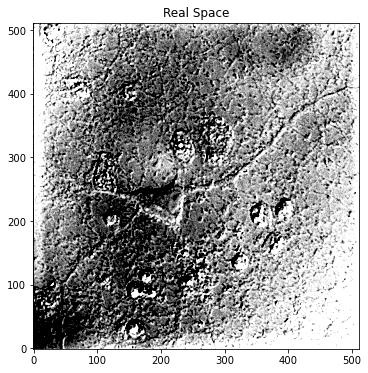

In [2]:
## Open the file. It was opened from FIJI and then File > save as > Tif

from skimage import io
img0 = io.imread('Rat_Hippocampal_Neuron.tif').astype('double') ## from FIJI examples

## Use the DIC image to find the aperture
img = img0[-1]

## Plot image
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.imshow(img,cmap='Greys_r',origin='lower',vmin=img.mean()-1.*img.std(),vmax=img.mean()+1.*img.std())
ax.set_title('Real Space')
plt.show()

In [3]:
## Calculate various Fourier transform things
ft = np.fft.fftshift(np.fft.fft2(img))
mag_img = np.sqrt(ft.real**2. + ft.imag**2.)
phase_img = np.unwrap(np.arctan(ft.imag/ft.real))
ln_mag = np.log(mag_img)

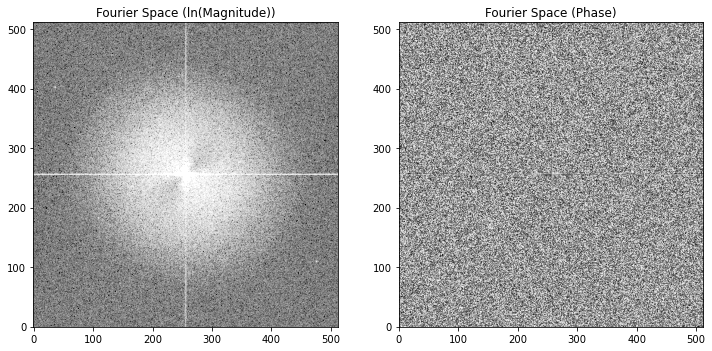

In [4]:
## Plot the magnitude and hase of the Fourier transform of the image
fig,ax=plt.subplots(1,2,figsize=(12,6))
vmin,vmax = np.percentile(ln_mag,(1,99))
ax[0].imshow(ln_mag,cmap='Greys_r',origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(phase_img,cmap='Greys_r',origin='lower')
ax[0].set_title('Fourier Space (ln(Magnitude))')
ax[1].set_title('Fourier Space (Phase)')
plt.show()

This evidence function calculates a circular mask/template given a radius, r0. Any pixels within r0 have value 1. and any outside r0 have value 0. It's like a 2D tophat function.

The evidence for this template is for m>0, b in R, tau>0 (SI 2.2.2). It is compared against the evidence for a flat or 'Null' template (i.e., m=0, b in R, tau >0 (SI 2.2.4).

This function returns the (negative) ratio of those two evidence functions so that the minimzer functions in scipy.optimize can find the maximum.

In [5]:
## pre-computed mask calculation parameters
nx,ny = ft.shape
kx,ky = np.mgrid[0:nx,0:ny]
kx = kx.astype('double') - nx/2.
ky = ky.astype('double') - ny/2.
kr2 = kx**2. + ky**2.

from scipy.special import betainc,betaln,gammaln
def ln_bayes_factor(theta,y):
	r0 = theta
	## model is out of bounds
	if r0 < 5:
		return np.inf

	## make the template 
	x = (kr2 < r0**2.).astype('double')
	N=float(x.size)

	ex = np.nanmean(x)
	exx = np.nanmean(x*x)
	ey = np.nanmean(y)
	eyy = np.nanmean(y*y)
	exy = np.nanmean(x*y)
	vx = exx - ex*ex + 1e-300
	vy = eyy - ey*ey + 1e-300
	vxy = exy - ex*ey + 1e-300
	r = vxy/np.sqrt(vx*vy)
	r2 = r*r
	if r2 < 1e-10 or r2 > 1.-1e-10:
		return np.inf
	M = (N-2.)/2.

	delm = 1e30
	lnR = np.log(2.) + np.log(delm) - betaln(.5,M) + .5*np.log(vx) - .5*np.log(vy) + M*np.log(1.-r2) - np.log(1.+np.sign(r)*betainc(.5,M,r2))
    
	return lnR

print(ln_bayes_factor((50.),ln_mag))

-13934.824440777767


  0%|          | 0/1000 [00:00<?, ?it/s]

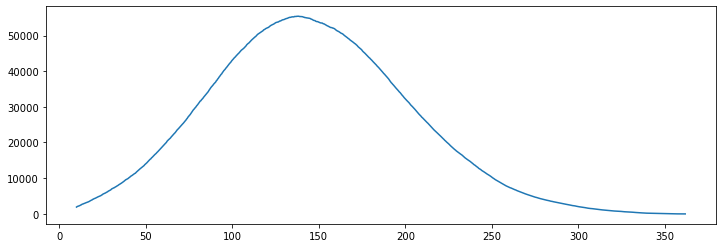

In [6]:
### Scan the r0 parameter to see if there is a maximum

xs = np.linspace(10,400,1000)*1.
ev = np.zeros_like(xs)
from tqdm.notebook import trange
for i in trange(xs.size):
    ev[i] = -ln_bayes_factor((xs[i]),ln_mag)
    
fig,ax = plt.subplots(1,figsize=(12,4))
ax.plot(xs,ev)
plt.show()

In [7]:
### Find the maximum prob aperture mask radius

from scipy.optimize import minimize

def wrapper(initial_guess,ln_mag):
    return -1./(1.+np.exp(ln_bayes_factor(initial_guess,ln_mag)))
    
initial_guess = np.array((xs[np.nanargmax(ev)]))
out = minimize(wrapper, initial_guess, args=ln_mag, method='Nelder-Mead')
print(out)

r0 = out.x
mask = (kr2 < r0**2.).astype('int')

 final_simplex: (array([[138.43843844],
       [138.43849125]]), array([-1., -1.]))
           fun: -1.0
       message: 'Optimization terminated successfully.'
          nfev: 53
           nit: 18
        status: 0
       success: True
             x: array([138.43843844])


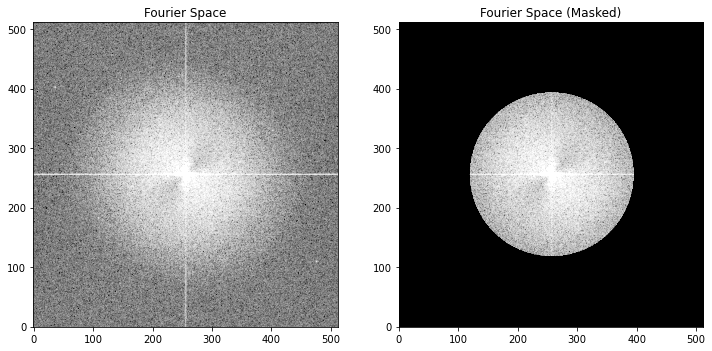

In [8]:
### Plot the best mask
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(ln_mag,cmap='Greys_r',origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(ln_mag*mask,cmap='Greys_r',origin='lower',vmin=vmin,vmax=vmax)
ax[0].set_title('Fourier Space')
ax[1].set_title('Fourier Space (Masked)')
plt.show()

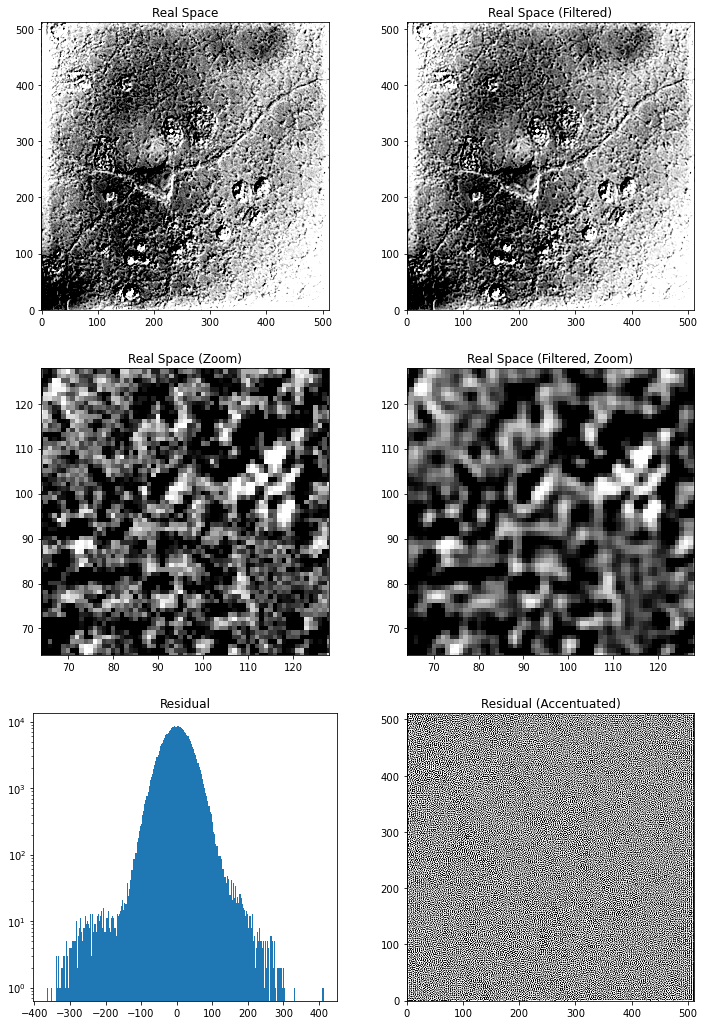

In [9]:
### Calculate and Plot the low pass filtered image
filtered = ft*(mask+mask*1j)
filtered = np.fft.ifft2(np.fft.fftshift(filtered)).real
residual = img-filtered

fig,ax=plt.subplots(3,2,figsize=(12,18))
ax[0,0].imshow(img,cmap='Greys_r',origin='lower',vmin=img.mean()-1.*img.std(),vmax=img.mean()+1.*img.std())
ax[0,1].imshow(filtered,cmap='Greys_r',origin='lower',vmin=img.mean()-1.*img.std(),vmax=img.mean()+1.*img.std())
ax[1,0].imshow(img,cmap='Greys_r',origin='lower',vmin=img.mean()-1.*img.std(),vmax=img.mean()+1.*img.std())
ax[1,1].imshow(filtered,cmap='Greys_r',origin='lower',vmin=img.mean()-1.*img.std(),vmax=img.mean()+1.*img.std())
ax[2,0].hist(residual.flatten(),bins=250,log=True)
ax[2,1].imshow(residual,cmap='Greys_r',origin='lower',vmin=np.percentile(residual,35),vmax=np.percentile(residual,65))

for aa in ax[1]:
    aa.set_xlim(64,128)
    aa.set_ylim(64,128)

ax[0,0].set_title('Real Space')
ax[0,1].set_title('Real Space (Filtered)')
ax[1,0].set_title('Real Space (Zoom)')
ax[1,1].set_title('Real Space (Filtered, Zoom)')
ax[2,0].set_title('Residual')
ax[2,1].set_title('Residual (Accentuated)')

plt.show()

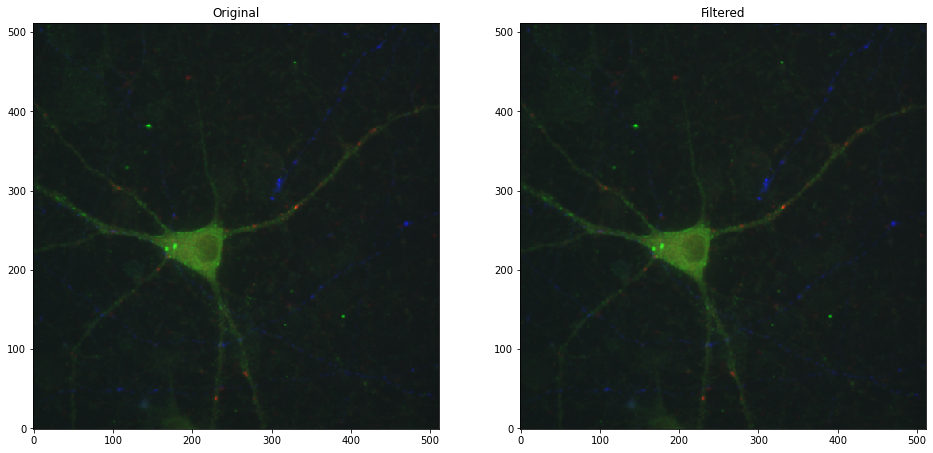

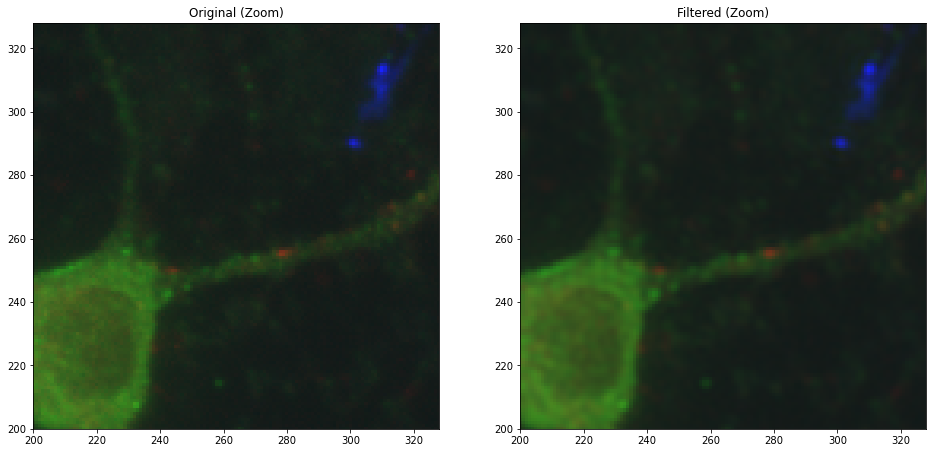

In [10]:
### Show the original and filtered image (first three fluorescence channels) in RGB
filtered = np.zeros((nx,ny,3))
full = np.zeros_like(filtered)
for i in range(3):
    ft = np.fft.fftshift(np.fft.fft2(img0[i]))
    fd = ft*(mask+mask*1j)
    fd = np.fft.ifft2(np.fft.fftshift(fd)).real
    filtered[:,:,i] = fd
    full[:,:,i] = img0[i]

scaling = full.max((0,1))[None,None,:]
filtered /= scaling
full /= scaling

fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(full,origin='lower',interpolation='nearest')
ax[1].imshow(filtered,origin='lower',interpolation='nearest')
ax[0].set_title('Original')
ax[1].set_title('Filtered')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(full,origin='lower',interpolation='nearest')
ax[1].imshow(filtered,origin='lower',interpolation='nearest')
ax[0].set_title('Original (Zoom)')
ax[1].set_title('Filtered (Zoom)')
for aa in ax:
    aa.set_xlim(200,328)
    aa.set_ylim(200,328)
plt.show()